# **Modèles pour classification textuelles**

Une fois les données nettoyées dans le notebook `1. Preprocessing` précédent, nous allons maintenant utiliser plusieurs modèles pour tenter de classifier les messages.

# 1. Avant propos et méthodologie

## 1.1 Premiers éléments

Nous allons faire de la classification textuelle avec _overlapping_ de labels. Il s'agit donc d'une _multilabel classification_ par opposition au _multiclass classification_ dans le cas où un seul label était possible par message. Pour traiter cela nous allons tout simplement séparer l'analyse en deux _binary classification_ simples : prédiction d'être `label 1` puis prédiction d'être `label 8`. La prédiction d'être `label 1:8` sera alors la simple combinaison des deux exercices précédents.


Par ailleurs les labels sont équilibrés, à priori pas besoin d'utiliser les méthodes spécifiques au _imbalanced dataset_ (over/undersampling, SMOTE, repondération des fonctions de loss)

## 1.2 Vectorisation des textes nettoyés

Afin de réaliser l'exercice en un temps raisonnable je me suis limité à prendre les modèles "sur étagère" largement connus et utilisés par la communauté plutôt que des algorithmes plus de niche/_state of the art_.

Le premier choix concerne l'implémentation d'un modèle transformant le texte nettoyé en un vecteur analysable par un algorithme de classification dans un second temps. Ces `vectorizers` retenus sont par ordre de complexité :
- (Non implémenté) One-Hot Vectorize/Bag of Words
- TF-IDF : une matrice _document term_ de même taille que précédemment mais mieux pondérée
- Embedding statique _a la_ word2vec : moyenne arithmétique des word2vec pour faire un Doc2Vec
- (Non implémenté) Combinaison des deux méthodes pour faire du doc/sent2vec où les pondérations par mot sont données par le TF-IDF
- Embedding "dynamique" en ayant recours à un transformers, ici camembert (BERT français)

## 1.3 Algorithmes de ML pour classification supervisée

Une fois la représentation plus ou moins dense retenue, il faut recourir un à algorithme de classification classique du machine learning. Pour en citer quelques-uns :
- Régression logistique simple ou pénalisée (Ridge, Lasso)
- SVM, particulièrement efficace pour des tâches de classification textuelle dans la mesure où elle prend efficacement en compte les matrices _sparses_ de TF-IDF
- XGBoost : "roi des compétitions Kaggle"

# 2. Packages usuels et importation

In [1]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

In [11]:
# Packages classiques
import pandas as pd
import numpy as np
import torch

# Custom package
import func_custom as fc

# NLP
import unicodedata
import spacy
import spacy_transformers
from transformers import CamembertModel, CamembertTokenizer


# Machine Learning
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [3]:
df = pd.read_csv("data/data_clean.csv",
                    sep = ";")

In [5]:
df["label_1"] = df["label"].apply(lambda x : "1" in x)
df["label_8"] = df["label"].apply(lambda x : "8" in x)

In [6]:
y_1 = df["label_1"]
y_8 = df["label_8"]

# 3. Comparaison des modèles de vectorisation

## 3.1 TF_IDF

L'approche "Bag of Word" (un one hot encoder des mots du vocabulaire) n'est pas montrée car le TF_IDF est une amélioration immédiation où au lieu d'avoir des simples 1 dans la matrice, les poids de chaque mots dans la phrase sont pondérés par un critère d'importance. La taille de la matrice reste cependnat la même.

In [92]:
messages = df["message_clean"]
# messages = df["message"].apply(lambda x: unicodedata.normalize("NFKC", x))

In [93]:
# Initialize the TF-IDF Vectorizer
# vectorizer = CountVectorizer() si BagOfWords/OneHotVectorizer
vectorizer = TfidfVectorizer(min_df = 2)

# Fit and transform the documents
X = vectorizer.fit_transform(messages)

In [94]:
pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out()).head()

,abattement,abord,aboutir,absence,absolument,accessible,accident,accompagner,accord,accueil,...,éventuel,éventuelle,éventuellement,évidemment,évident,évite,éviter,évoluer,évolution,évolué
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
y = y_1

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2)
                                                    # random_state = 42
# classifier = xgb.XGBClassifier()
classifier = LinearSVC()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)

In [96]:
print(report)

              precision    recall  f1-score   support

       False       0.81      0.80      0.80        64
        True       0.83      0.84      0.84        76

    accuracy                           0.82       140
   macro avg       0.82      0.82      0.82       140
weighted avg       0.82      0.82      0.82       140



In [97]:
# Travail "à la main" pour créer la visualisation des plus grandes contributions

coef = classifier.coef_[0]
vocabulary_positions = coef.argsort()
vocabulary = vectorizer.get_feature_names_out()

top_words = 20
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

df_contrib = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                          columns = ["feature", "coefficient"]).sort_values("coefficient")

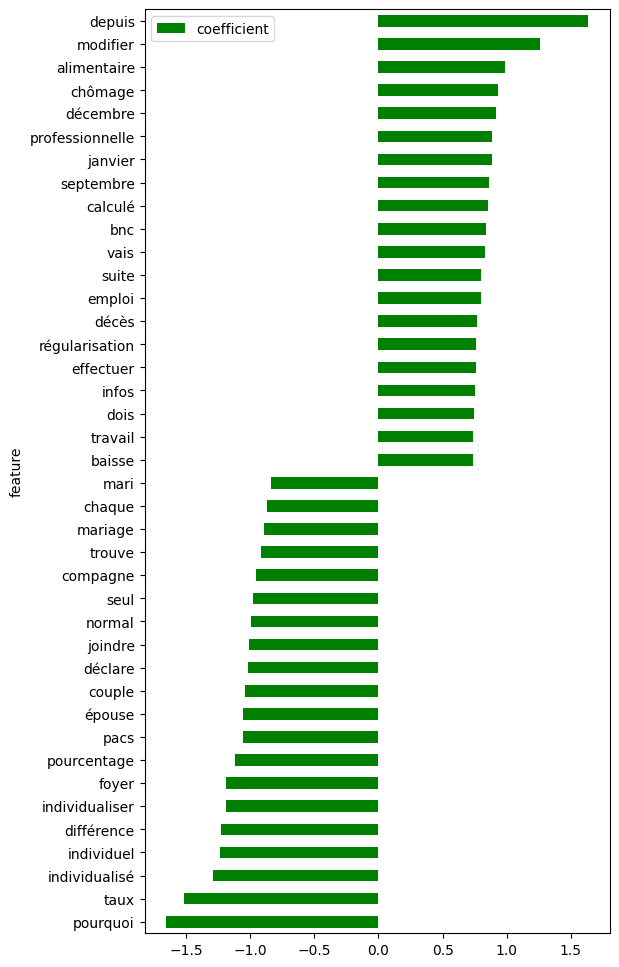

In [98]:
_ = df_contrib.set_index("feature").plot.barh(figsize = (6, 12), color = ["green", "red"])

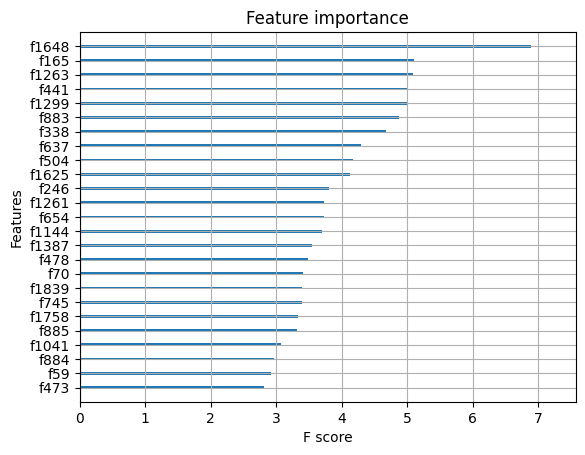

In [83]:
# En utilisant XGBoost cela aurait permit aussi une visualisation intégrée

# _ = xgb.plot_importance(classifier, 
#                         importance_type = "gain",
#                         max_num_features = 25,
#                         show_values = False)

## 3.2 Doc2Vec : Word2Vec issu de Spacy + moyenne arithmétique

Les messages adressés par les contribuables sont rédigés dans une langue orale/écrite courante et **ne présente pas de termes techniques/jargon spécifique**. Un embedding entraîné sur un corpus usuel sera donc suffisant pour ne pas entraîner de problème de dictionnaire. J'ai retenu par simplicité d'utilisation celui présent sur Spacy. Par économie de taille j'ai retenu un embedding "medium".

In [67]:
nlp = spacy.load("fr_core_news_lg")

In [68]:
df_spacy = df.copy()

In [69]:
df_spacy["embedding_avg"] = df_spacy["message_clean"].apply(lambda x: nlp(x).vector) # doc.vector donne l'embedding par moyenne arithmétique des mots de la phrase

In [70]:
df_embedding = pd.DataFrame()
for elem in df_spacy["embedding_avg"]:
    temp = (pd.DataFrame((elem)).T)
    df_embedding = pd.concat([df_embedding, temp])

df_embedding.to_csv("data_spacy.csv", sep = ";", index = False)

In [71]:
print(f"On passe de {X.shape[1]} features en TF-IDF à {df_embedding.shape[1]} features ici")

On passe de 300 features en TF-IDF à 300 features ici


In [72]:
y = y_1

X = df_embedding

# Step 3: Train a classifier
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 42)
# classifier = xgb.XGBClassifier()
classifier = LinearSVC()
classifier.fit(X_train, y_train)

# Step 4: Evaluate your model
y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)

In [73]:
print(report)

              precision    recall  f1-score   support

       False       0.75      0.71      0.73        70
        True       0.73      0.76      0.74        70

    accuracy                           0.74       140
   macro avg       0.74      0.74      0.74       140
weighted avg       0.74      0.74      0.74       140



## 3.3 Transformers : Camembert (RoBERTa)

On utilise Camembert directement. On aurait également pu passer par Spacy qui dispose d'un transformers français https://spacy.io/models/fr#fr_dep_news_trf

J'utilise ici une méthode simple "à la main" plutôt qu'un fine-tuning PyTorch (https://camembert-model.fr/posts/tutorial_part2/)

In [6]:
# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-base-wikipedia-4gb")
camembert = CamembertModel.from_pretrained("camembert/camembert-base-wikipedia-4gb")

c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [44]:
df_camembert  = pd.DataFrame()
for index, row in df_train.iterrows():
    message_raw = row["message"]

    tokenized_sentence = tokenizer.tokenize(message_raw)

    encoded_sentence = tokenizer.encode(tokenized_sentence)

    if (len(encoded_sentence) > 512) :
        encoded_sentence = encoded_sentence[:511]
        
    encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)

    results_camembert = camembert(encoded_sentence)

    new_row = pd.DataFrame(results_camembert.last_hidden_state.detach()[:,0,:])
    df_camembert = pd.concat([df_camembert, new_row], ignore_index = True)

df_camembert.to_csv("data/data_camembert.csv", sep = ";", index = False)

In [66]:
y = df_train["label_8"]
X = df_camembert

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7928571428571428


c:\Users\TitouanBlaize\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
print(report)

              precision    recall  f1-score   support

       False       0.78      0.74      0.76        61
        True       0.80      0.84      0.82        79

    accuracy                           0.79       140
   macro avg       0.79      0.79      0.79       140
weighted avg       0.79      0.79      0.79       140

